In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder # Importa LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA # Para visualização, se necessário

In [2]:
# dataset
try:
    df = pd.read_csv('../data/Breast_Cancer.csv')
except FileNotFoundError:
    print("Certifique-se de que 'data.csv' está no mesmo diretório.")
    exit()

#  cópia do dataframe original para manter o 'diagnosis' para análise
df_clustering = df.copy()

In [3]:
if 'id' in df_clustering.columns:
    df_clustering = df_clustering.drop(columns=['id'])
if 'Unnamed: 32' in df_clustering.columns:
    df_clustering = df_clustering.drop(columns=['Unnamed: 32'])

label_encoder = LabelEncoder()
df_clustering['diagnosis_encoded'] = label_encoder.fit_transform(df_clustering['diagnosis'])

# Separando as características para o clustering
# O clustering será feito apenas nas características numéricas
X_kmeans = df_clustering.drop(columns=['diagnosis', 'diagnosis_encoded'])

In [4]:
# Escalonação das características
scaler_kmeans = StandardScaler()
X_kmeans_scaled = scaler_kmeans.fit_transform(X_kmeans)

# converti de volta para DataFrame para manter nomes das colunas
X_kmeans_scaled_df = pd.DataFrame(X_kmeans_scaled, columns=X_kmeans.columns)

print("Dados preparados e escalados para K-Means. LabelEncoder configurado.")
print(f"Forma dos dados escalados: {X_kmeans_scaled.shape}")

Dados preparados e escalados para K-Means. LabelEncoder configurado.
Forma dos dados escalados: (569, 30)


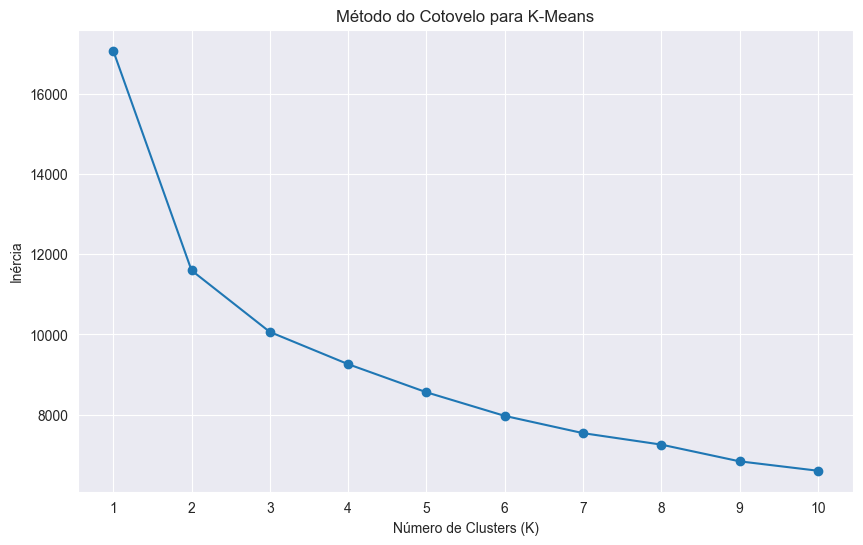

Gráfico do Método do Cotovelo gerado. Analise o gráfico para escolher o K ideal.
Um bom 'k' geralmente está no 'cotovelo' da curva, onde a taxa de queda da inércia diminui.


In [5]:
""" elbow method """

inertia = []
k_values = range(1, 11) # Vamos testar de 1 a 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init para robustez
    kmeans.fit(X_kmeans_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Método do Cotovelo para K-Means')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.xticks(k_values)
plt.grid(True)
plt.savefig('../Images/elbow_method.png') # Salva a figura
plt.show()

print("Gráfico do Método do Cotovelo gerado. Analise o gráfico para escolher o K ideal.")
print("Um bom 'k' geralmente está no 'cotovelo' da curva, onde a taxa de queda da inércia diminui.")

In [6]:
# K ideal = 2 (baseado no gráfico do cotovelo)

optimal_k = 2 # Exemplo: Escolhemos 2, pois esperamos dois grupos (M/B)

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_kmeans_scaled)

# Adicionar os rótulos dos clusters ao DataFrame de clustering
df_clustering['Cluster'] = kmeans_final.labels_

In [7]:
print(f"\n--- Análise dos Clusters (K={optimal_k}) ---")
print("Contagem de exemplos por cluster:")
print(df_clustering['Cluster'].value_counts())

print("\nDistribuição do 'diagnosis' original dentro de cada cluster:")
print(pd.crosstab(df_clustering['Cluster'], df_clustering['diagnosis']))


--- Análise dos Clusters (K=2) ---
Contagem de exemplos por cluster:
Cluster
0    375
1    194
Name: count, dtype: int64

Distribuição do 'diagnosis' original dentro de cada cluster:
diagnosis    B    M
Cluster            
0          339   36
1           18  176


In [8]:
# Centróides dos Clusters
print("\nCentróides dos Clusters (no espaço escalado - primeiras 5 características):")

# passando os centróides de volta para o DataFrame para visualização
centroids_df = pd.DataFrame(kmeans_final.cluster_centers_, columns=X_kmeans.columns)
print(centroids_df.head())


Centróides dos Clusters (no espaço escalado - primeiras 5 características):
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0    -0.482995     -0.239041       -0.500419  -0.478142        -0.311004   
1     0.933624      0.462065        0.967305   0.924243         0.601167   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0         -0.526019       -0.579036            -0.587171      -0.309084   
1          1.016789        1.119270             1.134996       0.597456   

   fractal_dimension_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0               -0.149141  ...     -0.517854      -0.251478        -0.532311   
1                0.288288  ...      1.001006       0.486104         1.028953   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0   -0.499358         -0.316078          -0.492241        -0.536843   
1    0.965253          0.610976           0.951497         1.037713   

   concave po

In [10]:
""" Visualização dos Clusters com PCA """

# baixei a dimensionalidade para 2 componentes principais
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_kmeans_scaled)

# criando um DataFrame só pro PCA para facilitar a plotagem
df_pca = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_pca['Cluster'] = df_clustering['Cluster']
df_pca['diagnosis_original'] = df_clustering['diagnosis']

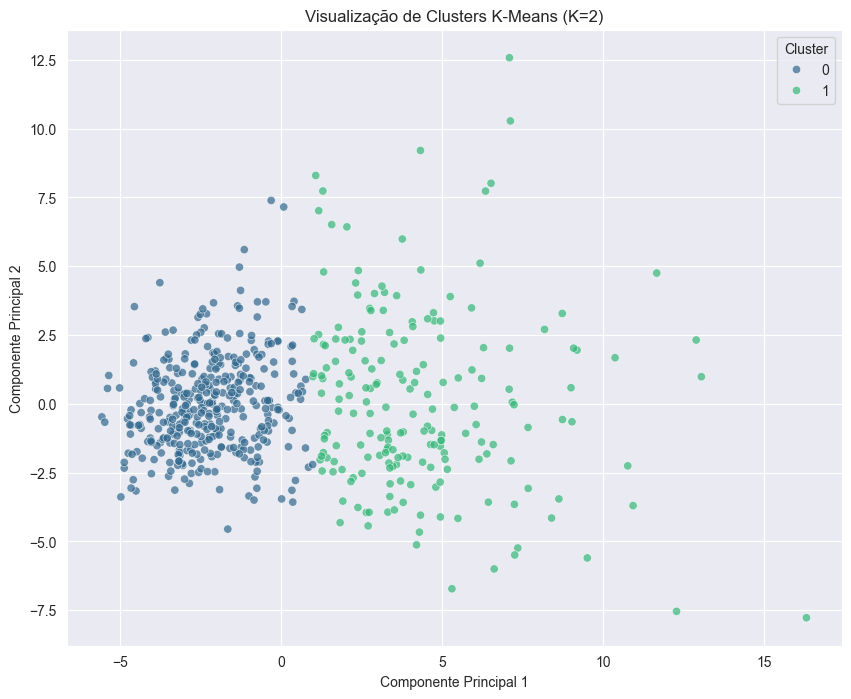

In [11]:
#fig 1
""" Clusters K=2 gerados pelo K-Means """
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster',
                palette='viridis', data=df_pca, legend='full', alpha=0.7)
plt.title(f'Visualização de Clusters K-Means (K={optimal_k})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.savefig('../Images/kmeans_clusters.png')
plt.show()

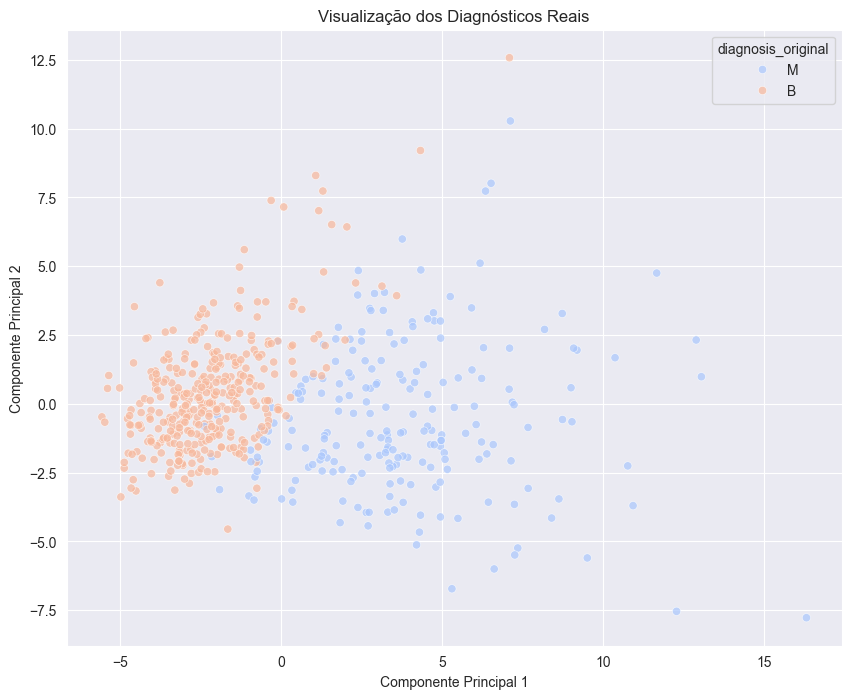

In [12]:
#fig 2
""" diagnóstico original nos clusters """

plt.figure(figsize=(10, 8))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='diagnosis_original',
                palette='coolwarm', data=df_pca, legend='full', alpha=0.7)
plt.title('Visualização dos Diagnósticos Reais')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.savefig('../Images/original_diagnosis_clusters.png')
plt.show()

#### Obs: Os gráficos obteveram uma grande semelhança, o que indica que os clusters formados pelo K-Means estão bem alinhados com os diagnósticos originais.